<a href="https://colab.research.google.com/github/glazar01/lyric-pulse-sentiment-analysis/blob/main/models/lyrics_analysis_all_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lyric Pulse: Evaluating Emotion Recognition Models on Song Lyrics

# Libraries

In [1]:
!pip install --no-cache-dir transformers sentencepiece

In [2]:
!pip3 install torch

In [17]:
pip install tensorflow

In [3]:
# import libraries
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import torch
import tensorflow as tf

# Import Data

## Single Label

In [4]:
s_url = "https://raw.githubusercontent.com/glazar01/lyric-pulse-sentiment-analysis/main/data/SingleLabel.csv"
s_data = pd.read_csv(s_url)

In [5]:
s_data.head()

,artist,genre,title,album,year,lyrics,label
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,Sadness
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,Tension
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,Tenderness
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...",Sadness
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,Sadness


## Multi Label

In [6]:
m_url = "https://raw.githubusercontent.com/glazar01/lyric-pulse-sentiment-analysis/main/data/MultiLabel.csv"
m_data = pd.read_csv(m_url)

In [7]:
m_data.head()

,artist,genre,title,album,year,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,"Calmness, Sadness"
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,"Power, Tension"
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,"Amazement, Calmness, Solemnity, Tenderness"
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...","Joyful activation, Sadness, Tension"
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,"Amazement, Calmness, Joyful activation"


# Useful Functions

1. Sentence segmentation

In [33]:
''' Segmentation in sentences for lyrics, removal of empty or duplicated sentences '''
def process_lyrics(text_data):
    def process_text(text):
        unique_sentences = set()
        processed_text = []

        for sentence in text.split('\n'):
            sentence_text = sentence.strip()
            if sentence_text and sentence_text not in unique_sentences:
                unique_sentences.add(sentence_text)
                processed_text.append(sentence_text)

        return processed_text

    processed_data = [process_text(row) for row in text_data]
    return processed_data

In [44]:
# Before sentence segmentation
s_data['lyrics'][0]

"I will never bother you\nI will never promise to\nI will never follow you\nI will never bother you\nNever speak a word again\nI will crawl away for good\nI will move away from here\nYou won't be afraid of fear\nNo thought was put into this\nAnd always knew it would come to this\nThings have never been so swell\nI have never failed to fail\n\nHe-eee-eee-eeey\nHe-eee-eee-eey\nHe-eee-eee-ey\nYou know you're right\nYou know you're right\nYou know you're right\n\nI'm so warm and calm inside\nI no longer have to hide\nLet's talk about someone else\nSteaming soup against her mouth\nNothing really bothers her\nShe just wants to love himself\nI will move away from here\nYou won't be afraid of fear\nNo thought was put into this\nAlways knew it'd come to this\nThings have never been so swell\nI have never failed to fail\n\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nHe-eee-eee-eey\nYou know you're right\nYou know you're right\nYou know you're right\nYou know you're right\nYou

In [41]:
processed_lyrics = process_lyrics(s_data['lyrics'])

In [42]:
# After sentence segmentation
processed_lyrics[0]

['I will never bother you',
 'I will never promise to',
 'I will never follow you',
 'Never speak a word again',
 'I will crawl away for good',
 'I will move away from here',
 "You won't be afraid of fear",
 'No thought was put into this',
 'And always knew it would come to this',
 'Things have never been so swell',
 'I have never failed to fail',
 'He-eee-eee-eeey',
 'He-eee-eee-eey',
 'He-eee-eee-ey',
 "You know you're right",
 "I'm so warm and calm inside",
 'I no longer have to hide',
 "Let's talk about someone else",
 'Steaming soup against her mouth',
 'Nothing really bothers her',
 'She just wants to love himself',
 "Always knew it'd come to this",
 '(He-eee-eee-eey)',
 'You know your rights']

2. Run the model and get sentiment scores (apply to models 1-3)

In [112]:
''' Runs the model (applying to models 1-3) on given lyrics and model's emotions and returns the sentiment scores'''
def get_sentiment_scores_by_sentences(lyrics, model, model_emotions):
    aggregated_scores = dict.fromkeys(model_emotions, 0)
    num_sentences = len(lyrics)

    # Process sentences in batches
    for i in range(num_sentences):
        sentence = lyrics[i]
        results_sentence = model(sentence)

        for result in results_sentence:
          for res in result:
            label = res['label']
            score = res['score']
            aggregated_scores[label] += score

    # Average the scores
    for label in aggregated_scores:
        aggregated_scores[label] /= num_sentences

    return aggregated_scores

In [ ]:
''' Function to run the model 4'''
def get_emotion(text, model):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length=2)

  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label

4. Find the emotion with the maximum score

In [47]:
def find_max_key(sentiment_scores, ignore_key='neutral'):
    second_max_keys = []
    for lyric_sentiment_scores in sentiment_scores:
        sorted_keys = sorted(lyric_sentiment_scores, key=lambda x: lyric_sentiment_scores[x], reverse=True)
        if sorted_keys[0] == ignore_key:
            # If the first key is 'Neutral' we consider the second key
            second_max_keys.append(sorted_keys[1])
        else:
            second_max_keys.append(sorted_keys[0])
    return second_max_keys

5. Calculate the accuracy of the model

In [156]:
''' Calculate the accuracy of a model. If singleLabel is true then we use the single label data set, otherwise the multi label.'''
def calculate_accuracy(original_emotions, predicted_emotions, singleLabel=True):
  if singleLabel:
    correct_predictions = sum(original == predicted for original, predicted in zip(original_emotions, predicted_emotions))
  else:
    correct_predictions = sum(predicted in {word.strip() for word in original.split(',')} for original, predicted in zip(original_emotions, predicted_emotions))
  return correct_predictions/len(original_emotions)

# Models

In [ ]:
from transformers import pipeline

In [115]:
models = []

In [53]:
model_emotions = {}

In [59]:
sentiment_scores = {}

In [148]:
dominant_sentiments = {}

In [72]:
emotion_mappings_single_label = {}
emotion_mappings_multi_label = {}

## Model 1:

In [116]:
models.append(pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None))

In [54]:
model_emotions[0] = ['love', 'admiration', 'approval', 'neutral', 'joy', 'optimism', 'gratitude', 'desire', 'annoyance', 'caring', 'disapproval', 'anger', 'realization', 'sadness', 'excitement', 'disappointment', 'amusement', 'confusion', 'disgust', 'curiosity', 'surprise', 'remorse', 'fear', 'nervousness', 'embarrassment', 'grief', 'pride', 'relief']

In [114]:
test_scores = get_sentiment_scores_by_sentences(processed_lyrics[0], models[0], model_emotions[0])
test_scores

{'love': 0.009968048295074064,
 'admiration': 0.013532166432317657,
 'approval': 0.08453840087167919,
 'neutral': 0.6173456426089009,
 'joy': 0.03887427455629222,
 'optimism': 0.03178784705232829,
 'gratitude': 0.0022090721528608506,
 'desire': 0.011329153622985663,
 'annoyance': 0.021234943269519135,
 'caring': 0.04287284387343485,
 'disapproval': 0.05202990907127969,
 'anger': 0.008183128569119921,
 'realization': 0.03795814326925514,
 'sadness': 0.009100369842296155,
 'excitement': 0.011620549544507716,
 'disappointment': 0.011168352837557904,
 'amusement': 0.004524723032470017,
 'confusion': 0.0027399567091682306,
 'disgust': 0.0024314690842099176,
 'curiosity': 0.002558888196896684,
 'surprise': 0.012454538523646383,
 'remorse': 0.0009703773527386753,
 'fear': 0.004743492247750207,
 'nervousness': 0.001677743804975762,
 'embarrassment': 0.0015005429074032388,
 'grief': 0.0009234571783357145,
 'pride': 0.0019465359170377876,
 'relief': 0.0056654434720257996}

In [73]:
emotion_mappings_single_label[0] = {
    'love' : 'Tenderness',
    'admiration' : 'Tenderness',
    'approval' : 'Tenderness',
    'joy' : 'Tenderness',
    'optimism' : 'Tenderness',
    'gratitude' : 'Tenderness',
    'desire' : 'Tension',
    'annoyance' : 'Tension',
    'caring' : 'Tenderness',
    'disapproval' : 'Tension',
    'anger' : 'Tension',
    'realization' : 'Tension',
    'sadness' : 'Sadness',
    'excitement' : 'Tension',
    'disappointment' : 'Sadness',
    'amusement' : 'Tenderness',
    'confusion' : 'Tension',
    'disgust' : 'Tension',
    'curiosity' : 'Tension',
    'surprise' : 'Tension',
    'remorse' : 'Sadness',
    'fear' : 'Tension',
    'nervousness' : 'Tension',
    'embarrassment' : 'Tension',
    'grief' : 'Sadness',
    'pride' : 'Tenderness',
    'relief' : 'Tenderness'
}

## Model 2:

In [117]:
models.append(pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True))

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [89]:
test_scores = get_sentiment_scores_by_sentences(processed_lyrics[0], models[1], model_emotions[1])
test_scores

{'anger': 0.1198090743952586,
 'disgust': 0.11130956945028932,
 'fear': 0.0936418952672587,
 'joy': 0.14156872494398462,
 'neutral': 0.3558837102415661,
 'sadness': 0.1331049094927342,
 'surprise': 0.04468212039986005}

In [64]:
model_emotions[1] = ["anger","disgust","fear","joy","neutral","sadness","surprise"]

In [74]:
emotion_mappings_single_label[1] = {
    'anger': 'Tension',
    'disgust': 'Tension',
    'fear': 'Tension',
    'joy': 'Tenderness',
    'anger': 'Tension',
    'sadness': 'Sadness',
    'surprise': 'Tension'
}

## Model 3:

In [118]:
models.append(pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True))

In [93]:
model_emotions[2] = ['sadness','joy','love','anger','fear','surprise']

In [94]:
emotion_mappings_single_label[2] = {
    'sadness': 'Sadness',
    'joy': 'Tenderness',
    'love': 'Tenderness',
    'anger': 'Tension',
    'fear': 'Tension',
    'surprise': 'Tension'
}

In [95]:
test_scores = get_sentiment_scores_by_sentences(processed_lyrics[0], models[2], model_emotions[2])
test_scores

{'sadness': 0.1231724840120781,
 'joy': 0.29729707747416495,
 'love': 0.005218274750707981,
 'anger': 0.47074906077493023,
 'fear': 0.10181797693924939,
 'surprise': 0.0017451177263865247}

## Run for models 1-3

In [141]:
for i in range(len(models)-1):
  sentiment_scores[i] = [get_sentiment_scores_by_sentences(lyrics, models[i], model_emotions[i]) for lyrics in processed_lyrics]

In [149]:
for i in range(len(sentiment_scores)):
  dominant_sentiments[i] = find_max_key(sentiment_scores[i], ignore_key='neutral')

## Model4: t-5 base-finetuned-emotion

For this model it is a little bit different, that's why we create a different function to handle it.

In [98]:
from transformers import AutoTokenizer, AutoModelWithLMHead
from nltk.tokenize import sent_tokenize

In [119]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
models.append(AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion"))

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1499: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
emotion_mappings_single_label[3] = {
    'sadness': 'Sadness',
    'joy': 'Tenderness',
    'love': 'Tenderness',
    'anger': 'Tension',
    'fear': 'Tension',
    'surprise': 'Tension'
}

In [ ]:
model_emotions[3] = ['sadness','joy','love','anger','fear','surprise']

# Splitting sentences

## Using sent_tokenize

In [104]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [130]:
from nltk.tokenize import sent_tokenize
from collections import Counter

def get_aggregated_emotion_for_lyrics(lyrics, model):
    # sentences = sent_tokenize(lyrics)
    emotions = [get_emotion(sentence, model) for sentence in lyrics]
    filtered_emotions = [sentence.replace('<pad> ', '') for sentence in emotions]
    most_common_emotion = Counter(filtered_emotions).most_common(1)[0][0]
    return most_common_emotion

In [131]:
get_aggregated_emotion_for_lyrics(processed_lyrics[0], models[3])

'anger'

In [151]:
dominant_sentiments[3] = [get_aggregated_emotion_for_lyrics(lyrics, models[3]) for lyrics in processed_lyrics]

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


# Model Evaluation

In [155]:
total_songs = len(s_data)

In [163]:
emotion_mappings = {
    'love' : {'Single': 'Tenderness','Multi' : 'Tenderness'},
    'admiration' : {'Single': 'Tenderness','Multi' : 'Amazement'},
    'approval' : {'Single': 'Tenderness','Multi' : 'Power'},
    'joy' : {'Single': 'Tenderness','Multi' : 'Joyful activation'},
    'optimism' : {'Single': 'Tenderness','Multi' : 'Joyful activation'},
    'gratitude' : {'Single': 'Tenderness','Multi' : 'Power'},
    'desire' : {'Single': '','Multi' : 'Nostalgia'},
    'annoyance' : {'Single': 'Tension','Multi' : 'Tension'},
    'caring' : {'Single': 'Tenderness','Multi' : 'Tenderness'},
    'disapproval' : {'Single': 'Tension','Multi' : 'Tension'},
    'anger' : {'Single': 'Tension','Multi' : 'Tension'},
    'realization' : {'Single': 'Tension','Multi' : 'Solemnity'},
    'sadness' : {'Single': 'Sadness','Multi' : 'Sadness'},
    'excitement' : {'Single': 'Tension','Multi' : 'Joyful activation'},
    'disappointment' : {'Single': 'Sadness', 'Multi' : 'Sadness'},
    'amusement' : {'Single': 'Tenderness','Multi' : 'Joyful activation'},
    'confusion' : {'Single': 'Tension','Multi' : 'Tension'},
    'disgust' : {'Single': 'Tension','Multi' : 'Tension'},
    'curiosity' : {'Single': 'Tension','Multi' : 'Tension'},
    'surprise' : {'Single': 'Tension','Multi' : 'Amazement'},
    'remorse' : {'Single': 'Sadness','Multi' : 'Sadness'},
    'fear' : {'Single': '','Multi' : 'Tension'},
    'nervousness' : {'Single': 'Tension','Multi' : 'Tension'},
    'embarrassment' : {'Single': 'Tension','Multi' : 'Tension'},
    'grief' : {'Single': 'Sadness','Multi' : 'Sadness'},
    'pride' : {'Single': 'Tenderness','Multi' : 'Joyful activation'},
    'relief' : {'Single': 'Tenderness','Multi' : 'Tenderness'}
}

In [157]:
s_mapped_predictions = {}
m_mapped_predictions = {}

In [167]:
s_accuracy = {}
m_accuracy = {}

## Single Label

In [159]:
s_original_emotions = s_data['label']

In [168]:
for i in range(len(models)):
  s_mapped_predictions[i] = [emotion_mappings[dominant]['Single'] for dominant in dominant_sentiments[i]]
  s_accuracy[i] = calculate_accuracy(s_original_emotions, s_mapped_predictions[i])

In [169]:
s_accuracy

{0: 0.45, 1: 0.4267241379310345, 2: 0.3758620689655172, 3: 0.36982758620689654}

## Multi Label

In [170]:
m_original_emotions = m_data['labels']

In [173]:
emotion_mappings['admiration']['Multi']

'Amazement'

In [175]:
for i in range(len(models)):
  m_mapped_predictions[i] = [emotion_mappings[dominant]['Multi'] for dominant in dominant_sentiments[i]]
  m_accuracy[i] = calculate_accuracy(m_original_emotions, m_mapped_predictions[i],singleLabel=False)

In [176]:
m_accuracy

{0: 0.6120689655172413,
 1: 0.5793103448275863,
 2: 0.5232758620689655,
 3: 0.4939655172413793}

# Visualization

In [ ]:
pip install matplotlib seaborn

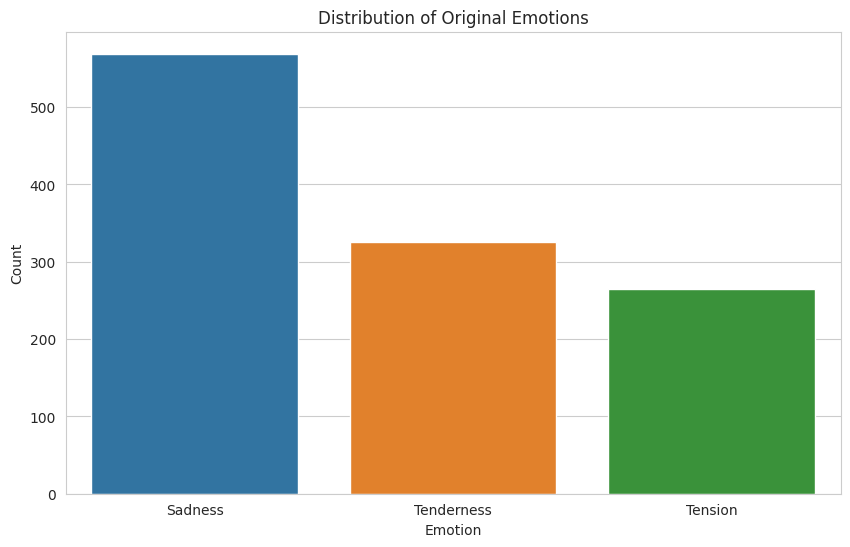

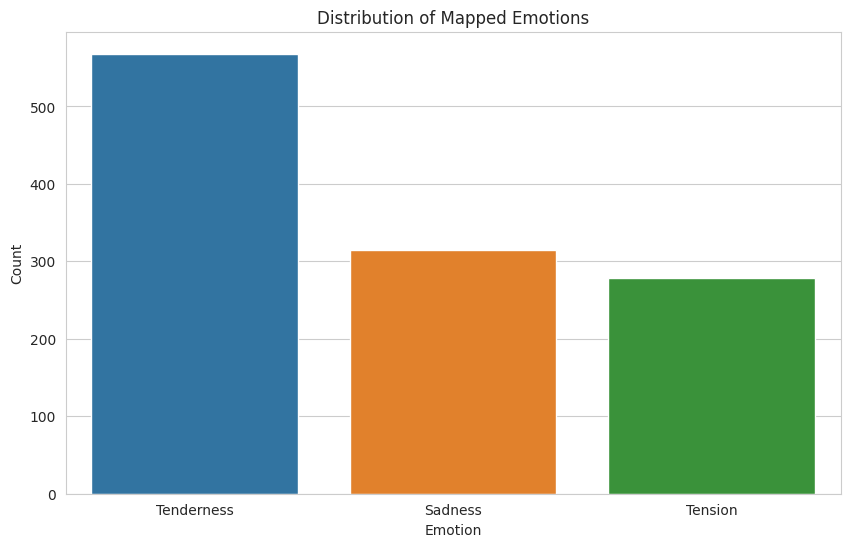

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for seaborn
sns.set_style("whitegrid")

# Plot for original_emotion distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=s_data, x='label', order=s_data['label'].value_counts().index)
plt.title('Distribution of Original Emotions')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.show()

# Plot for mapped_emotion distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=s_data, x='mapped_emotion', order=s_data['mapped_emotion'].value_counts().index)
plt.title('Distribution of Mapped Emotions')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.show()

<ipython-input-58-5c15e2da70f4>:10: RuntimeWarning: invalid value encountered in divide
  accuracies = cm.diagonal() / cm.sum(axis=1)


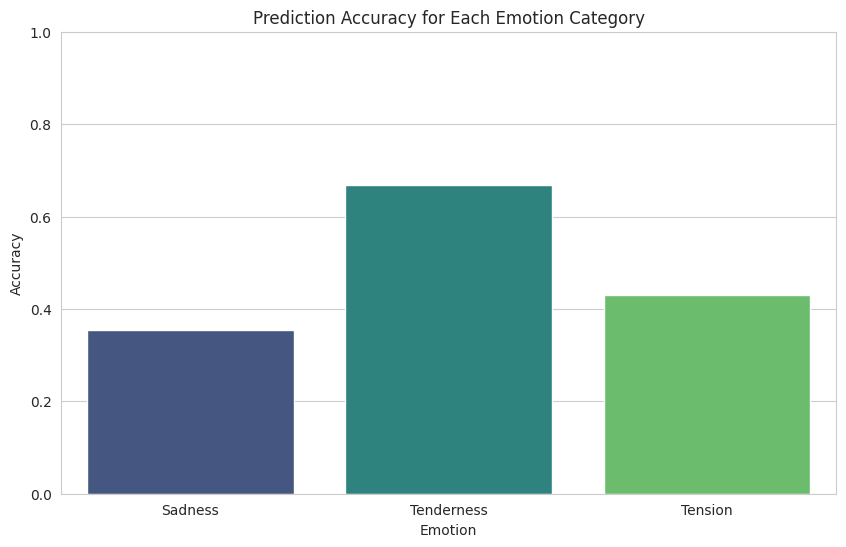

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(original_emotion, mapped_emotion, labels=list(emotion_mapping.values()))

# Calculate per-category accuracy
accuracies = cm.diagonal() / cm.sum(axis=1)

# Mapping of emotions to their accuracies
emotion_accuracy = dict(zip(list(emotion_mapping.values()), accuracies))

# Visualize the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_accuracy.keys()), y=list(emotion_accuracy.values()), palette="viridis")
plt.title('Prediction Accuracy for Each Emotion Category')
plt.ylabel('Accuracy')
plt.xlabel('Emotion')
plt.ylim(0, 1)  # Setting y-axis limits to be between 0 and 1 for clarity
plt.show()

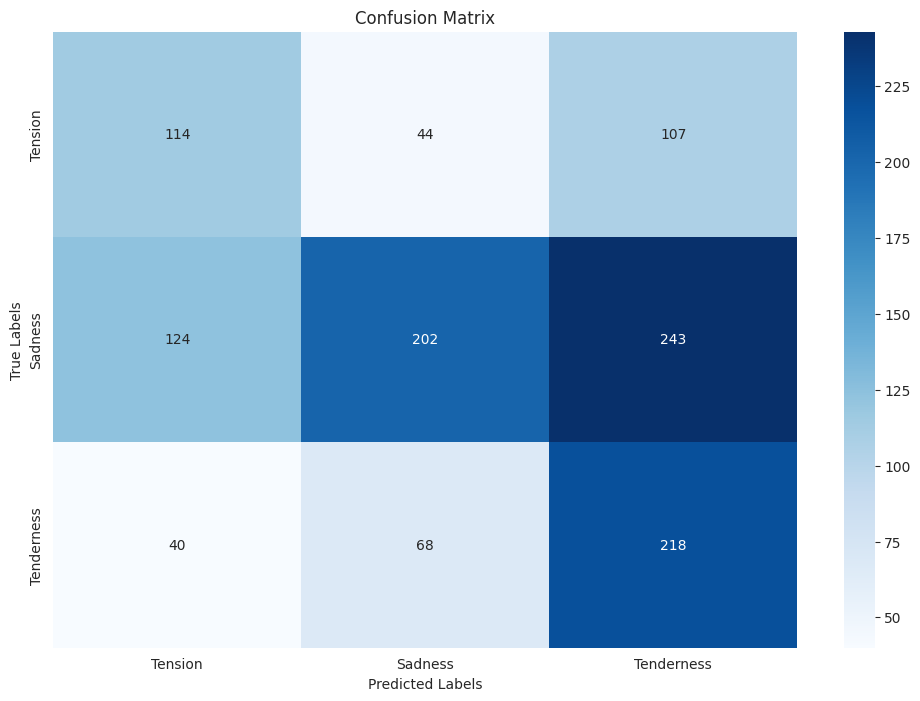

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique labels from both original and mapped emotions
unique_labels = list(set(original_emotion) | set(mapped_emotion))

# Calculate the confusion matrix
cm = confusion_matrix(original_emotion, mapped_emotion, labels=unique_labels)

# Visualize the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()